In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open("1.Abstract.txt").read().splitlines()
words[:10]

['March 2024',
 '',
 'I met the Reddits before we even started Y Combinator. In fact they were one of the reasons we started it.',
 '',
 "YC grew out of a talk I gave to the Harvard Computer Society (the undergrad computer club) about how to start a startup. Everyone else in the audience was probably local, but Steve and Alexis came up on the train from the University of Virginia, where they were seniors. Since they'd come so far I agreed to meet them for coffee. They told me about the startup idea we'd later fund them to drop: a way to order fast food on your cellphone.",
 '',
 "This was before smartphones. They'd have had to make deals with cell carriers and fast food chains just to get it launched. So it was not going to happen. It still doesn't exist, 19 years later. But I was impressed with their brains and their energy. In fact I was so impressed with them and some of the other people I met at that talk that I decided to start something to fund them. A few days later I told Steve

In [5]:
len(words)

8467

In [6]:
### mappings 
chars = sorted(list(set("".join(words))))
if "." in chars:
    stoi = {s:i for i,s in enumerate(chars)}
else:
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi["."] = 0
    
itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

In [16]:
stoi

{'\t': 0,
 ' ': 1,
 '!': 2,
 '"': 3,
 '$': 4,
 '%': 5,
 '&': 6,
 "'": 7,
 '(': 8,
 ')': 9,
 '*': 10,
 '+': 11,
 ',': 12,
 '-': 13,
 '.': 14,
 '/': 15,
 '0': 16,
 '1': 17,
 '2': 18,
 '3': 19,
 '4': 20,
 '5': 21,
 '6': 22,
 '7': 23,
 '8': 24,
 '9': 25,
 ':': 26,
 ';': 27,
 '<': 28,
 '=': 29,
 '>': 30,
 '?': 31,
 '@': 32,
 'A': 33,
 'B': 34,
 'C': 35,
 'D': 36,
 'E': 37,
 'F': 38,
 'G': 39,
 'H': 40,
 'I': 41,
 'J': 42,
 'K': 43,
 'L': 44,
 'M': 45,
 'N': 46,
 'O': 47,
 'P': 48,
 'Q': 49,
 'R': 50,
 'S': 51,
 'T': 52,
 'U': 53,
 'V': 54,
 'W': 55,
 'X': 56,
 'Y': 57,
 'Z': 58,
 '[': 59,
 ']': 60,
 '^': 61,
 '_': 62,
 'a': 63,
 'b': 64,
 'c': 65,
 'd': 66,
 'e': 67,
 'f': 68,
 'g': 69,
 'h': 70,
 'i': 71,
 'j': 72,
 'k': 73,
 'l': 74,
 'm': 75,
 'n': 76,
 'o': 77,
 'p': 78,
 'q': 79,
 'r': 80,
 's': 81,
 't': 82,
 'u': 83,
 'v': 84,
 'w': 85,
 'x': 86,
 'y': 87,
 'z': 88,
 '|': 89,
 '²': 90,
 'à': 91,
 'é': 92,
 'ê': 93,
 'ö': 94,
 '–': 95,
 '—': 96,
 '’': 97,
 '≈': 98}

In [7]:
vocab_size

99

In [8]:
## build the dataset
block_size = 8

def build_data(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + ".":
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr   = build_data(words[:n1])     ## train 80%
Xval, Yval = build_data(words[n1:n2])   ## val   10%
Xte, Yte   = build_data(words[n2:])     ## test  10%


torch.Size([1075300, 8]) torch.Size([1075300])
torch.Size([143184, 8]) torch.Size([143184])
torch.Size([135902, 8]) torch.Size([135902])


In [9]:
g = torch.Generator().manual_seed(2100)

############################################## LINEAR LAYER ##############################################
class Linear:

    def __init__(self, fan_in, fan_out, generator = g, bias = True):
        self.weights = torch.randn((fan_in, fan_out),  generator = g) * (1/fan_in**0.5)
        self.bias  = torch.randn(fan_out,  generator = g) if bias else None
        self.training = True
        
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])
    
############################################## BATCH NORM LAYER ##############################################

class BatchNormld:
    
    def __init__(self, dim, eps= 1e-5, momentum = 0.01,training = True):
        
        self.eps = eps
        self.momentum = momentum
        
        self.training = True
        ## trainable parameters
        self.gamma = torch.ones((dim,))
        self.beta  = torch.zeros((dim,))
        
        ## running estimates of mean and var
        
        self.mean_running = torch.zeros((dim,))
        self.var_running  = torch.ones((dim,))
        
    def __call__(self, x):
        
        if self.training:
            
            xmean = x.mean(0, keepdim = True)
            xvar  = x.var(0, keepdim = True)
        else:
            
            xmean = self.mean_running
            xvar  = self.var_running
            
        with torch.no_grad():
            if self.training:
                self.mean_running = (1-self.momentum)*self.mean_running + self.momentum*xmean
                self.var_running  = (1-self.momentum)*self.var_running  + self.momentum*xvar
        
        self.out = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma * self.out + self.beta
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
############################################## TANH LAYER ##############################################
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
############################################# Embedding layer ##########################################################

class Embedding:
    def __init__(self, vocab_size, n_emb, generator = g):
        self.C = torch.randn((vocab_size, n_emb),  generator = g) 
        self.training = True
        
    def __call__(self, x):
        self.out = self.C[x]
        return self.out
    
    def parameters(self):
        return [self.C] 
############################################# Flatten Layer ##########################################################

class Flatten:
    
    def __call__(self, x): 
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return [] 

############################################# Container ##########################################################
 
class Sequential:
    
    def __init__(self, layers, generator = g):
        self.layers = layers
        self.training = True
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        parameters = [p for layer in layers for p in layer.parameters()]
        return parameters 
    

In [10]:
g = torch.Generator().manual_seed(1245)
nemb    = 20
nhidden = 200

# the model

layers = [Embedding(vocab_size, nemb),Flatten(),
          Linear(block_size*nemb, nhidden, generator = g), BatchNormld(nhidden), Tanh(),
          Linear(nhidden, nhidden, generator = g), BatchNormld(nhidden), Tanh(),
          Linear(nhidden, vocab_size, generator = g)]

model = Sequential(layers)


with torch.no_grad():
 # make model less confident at initialization
    model.layers[-1].weights *= 0.1
 # apply gain for well behaved inputs to Tanh
    for layer in model.layers[1:-1]: ## not applied to the Emb and last layers
        if  isinstance(layer, Linear):
            layer.weights *= 5/3      #### Kaiming Normalization

            
for p in model.parameters():
    p.requires_grad = True
    


In [11]:
### Stochastic Gradient Descent

epochs     = 200000
batch_size = 200
history    = []
ud         = [] ## update ratio (lr x grad/data)
for epoch in range(epochs):
    
    ## Construct Mini Batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    xb, yb = Xtr[ix], Ytr[ix]
    
    ## forward pass
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)
    
    ## Backward pass
    for layer in model.layers:
        layer.out.retain_grad() ## would take out the retain graph
        
    for p in model.parameters():
        p.grad = None
    
    loss.backward()
    
    ## update
    
    lr = 0.01 if epoch < 100000 else 0.001
    
    for p in model.parameters():
        p.data -= lr*p.grad
    
    ## track stats
    if epoch%10000 == 0:
        print(f'{epoch:7d}/{epochs:7d} : {loss.item():.4f}')
        
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in model.parameters()])
        
    history.append(loss.item())
    
#     break

      0/ 200000 : 4.9717
  10000/ 200000 : 2.4498
  20000/ 200000 : 2.1000
  30000/ 200000 : 1.9588
  40000/ 200000 : 1.9087
  50000/ 200000 : 1.7695
  60000/ 200000 : 1.6335
  70000/ 200000 : 1.7715
  80000/ 200000 : 1.9047
  90000/ 200000 : 1.6648
 100000/ 200000 : 1.5195
 110000/ 200000 : 1.3596
 120000/ 200000 : 1.5022
 130000/ 200000 : 1.4068
 140000/ 200000 : 1.4086
 150000/ 200000 : 1.4508
 160000/ 200000 : 1.4323
 170000/ 200000 : 1.5209
 180000/ 200000 : 1.4135
 190000/ 200000 : 1.4949


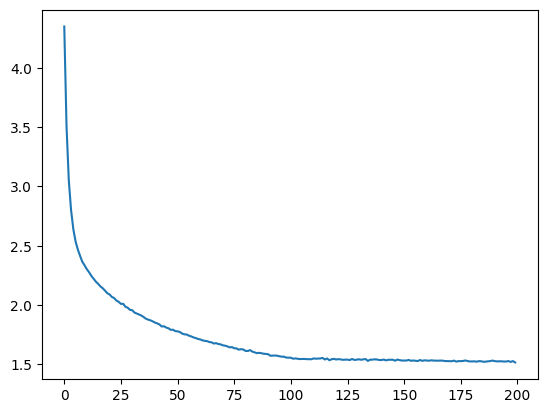

In [12]:
plt.plot(torch.tensor(history).view(-1, 1000).mean(1));

In [13]:
### Put model in train == False model
for layer in model.layers:
    layer.training = False

In [14]:
## Evaluate the model
@torch.no_grad() ## disables grad tracking
def split_loss(split):
    x,y = {'train': (Xtr, Ytr),
           'val':   (Xval, Yval),
           'test':  (Xte, Yte)}[split]
    
    logits = model(x)
    loss   = F.cross_entropy(logits, y)
    
    print(split, loss.item())
    
split_loss('train')
split_loss('val')
# split_loss('test') 

train 1.506914734840393
val 1.5286625623703003


In [17]:
## sampling from the models - generation step

g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out     = []
    context = [0]*block_size
    
    while True:
        
        logits   = model(torch.tensor(context).view(1,-1))
        probs    = F.softmax(logits, dim = 1)
        ix       = torch.multinomial(probs, num_samples = 1, generator =g).item()
        context  = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 14:
            break
        
    print("".join(out))

[6] Then yous lonce can make ad wnongh that the wars to atties this sormbarwe times that took at 20ur sexmpere, ingreses not get expandes when you start checeftumenfion of onal a company to heaving on finanated in somethe impricive.
[4] Those diggress.
.
It pearfially not more than schere uf the ciry 1’ you osteal ant a lot exammant.
.
Yowhere were have you're actual fivien as impore end unless while sperious ay hackants for (ar.
.
ITeties possence started because when stoond this will that's hard even I Soluoragh.
Thede worked the trentless and then tit shoupp because comme6tattee injection of as binly, get, but is espectuct, say ot like happintently othens oun port-erudent of onavrays.
.
.
Meraing the Futwerforless.
	When Svast bod fact and stoboch on Eortimmed the nues.
[2] >7 jas in your fram Wo bust of the big is nuar s of progging things, it didn't we de off yid light did, were proken you're carent to genarely wriving we promes.
And sige for be racarmss attentiate.
In un the attr

In [ ]:
## Visualization of what's happening